In [ ]:
#pip install scanpy

In [4]:
################ scATACseq Preprocessing  ################

#--------------------------------------
# Step 1: Import and Read scATAC-seq Data
# --------------------------------------
# ================================================================
# 📌 NOTE: Manual parsing of 10X scATAC-seq HDF5 matrix
# ================================================================
# This script uses a custom approach to load scATAC-seq data from 
# 10X Genomics because scanpy.read_10x_h5() does not fully support 
# the structure of scATAC-seq peak-barcode matrices.
#
# Unlike standard scRNA-seq HDF5 files, scATAC-seq matrices:
#   - Store data in compressed sparse column (CSC) format.
#   - Contain peak features under 'features' and 'name'.
#   - Are returned by scanpy with shape (n_cells, 0) if improperly parsed.
#
# To correctly load the data:
#   - We use h5py to extract 'data', 'indices', 'indptr', and 'shape'.
#   - We build the sparse matrix manually and transpose it to match 
#     the (cells × peaks) format expected by AnnData.
#   - We also manually assign peak names and cell barcodes.
#
# This workaround ensures a complete and accurate representation 
# of the scATAC-seq data for downstream analysis.
# ================================================================

import scanpy as sc
import numpy as np
import pandas as pd
import scipy.sparse as sp
import h5py
from anndata import AnnData

# Set Scanpy verbosity and figure parameters
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=100)

# 📂 Path to raw 10x Genomics scATAC-seq file
h5_file = "atac_pbmc_10k_nextgem_filtered_peak_bc_matrix.h5"
print(f"📂 Reading {h5_file}")

# 🔍 Manually read internal structure
with h5py.File(h5_file, "r") as f:
    group = f['matrix']
    barcodes = group['barcodes'][:].astype(str)
    data = group['data'][:]
    indices = group['indices'][:]
    indptr = group['indptr'][:]
    shape = group['shape'][:]  # shape = (n_peaks, n_cells)

    features = group['features']
    peak_names = features['name'][:].astype(str) if 'name' in features else None

# 🧩 Construct sparse matrix in CSC format (peaks x cells)
X_csc = sp.csc_matrix((data, indices, indptr), shape=shape)

# 🔄 Transpose to get (cells x peaks) for AnnData
X = X_csc.transpose().tocsr()

# ✅ Verify shapes
print(f"✅ Loaded matrix with shape: {X.shape}")
print(f"🧬 Cells: {X.shape[0]} | 🧬 Peaks: {X.shape[1]}")
print(f"🔎 Matrix dtype: {X.dtype}")
print(f"🧼 Contains NaNs? {np.isnan(X.data).any()}")

# 🏗️ Create AnnData object
adata = AnnData(X=X, dtype='float32')
adata.obs_names = pd.Index(barcodes.astype(str), name="cell_barcode")
adata.var_names = pd.Index(peak_names.astype(str), name="peak") if peak_names is not None else pd.Index([f"peak_{i}" for i in range(X.shape[1])])

# 🧾 Summary
print(f"✅ Final AnnData shape: {adata.shape}  (cells, peaks)")
print("🔎 First 5 peak names:", adata.var_names[:5].tolist())
print("🔎 First 5 cell barcodes:", adata.obs_names[:5].tolist())


📂 Reading atac_pbmc_10k_nextgem_filtered_peak_bc_matrix.h5
✅ Loaded matrix with shape: (9668, 90686)
🧬 Cells: 9668 | 🧬 Peaks: 90686
🔎 Matrix dtype: int32
🧼 Contains NaNs? False
✅ Final AnnData shape: (9668, 90686)  (cells, peaks)
🔎 First 5 peak names: ['chr1:565163-565491', 'chr1:569190-569620', 'chr1:713551-714783', 'chr1:752418-753020', 'chr1:762249-763345']
🔎 First 5 cell barcodes: ['AAACGAAAGAGCTGTG-1', 'AAACGAAAGCCTCGCA-1', 'AAACGAAAGCGAGCTA-1', 'AAACGAAAGCGCCTAC-1', 'AAACGAAAGGGAGTTC-1']


In [5]:
# ---------------------------------------------
# 2. Basic QC Metrics for scATAC-seq Data
# ---------------------------------------------
import numpy as np

# Total fragments (i.e., accessibility counts) per cell
adata.obs['total_counts'] = np.array(adata.X.sum(axis=1)).flatten()

# Number of detected peaks per cell (non-zero entries)
adata.obs['n_peaks'] = np.array((adata.X > 0).sum(axis=1)).flatten()

# Summary statistics
print("📊 QC summary (per cell):")
print(adata.obs[['total_counts', 'n_peaks']].describe())

# Optional: filter cells with very low signal (e.g., < 1000 counts or < 500 peaks)
min_counts = 1000
min_peaks = 500
initial_n_cells = adata.n_obs

adata = adata[adata.obs['total_counts'] >= min_counts, :]
adata = adata[adata.obs['n_peaks'] >= min_peaks, :]

print(f"✅ After filtering: {adata.n_obs} cells retained (out of {initial_n_cells})")


📊 QC summary (per cell):
        total_counts       n_peaks
count    9668.000000   9668.000000
mean    18827.363281   7134.865329
std      9472.375000   2988.041027
min      1674.000000    806.000000
25%     12435.250000   5069.000000
50%     17566.000000   6848.500000
75%     23428.500000   8839.500000
max    103764.000000  28025.000000
✅ After filtering: 9668 cells retained (out of 9668)


In [ ]:
#QC #Summary Interpretation
#scATAC-seq dataset shows a healthy distribution of total counts and detected peaks per cell. The median cell has ~17,566 fragments and ~6,849 accessible peaks, indicating good sequencing depth and complexity. All cells exceed the minimal QC thresholds (≥1000 total counts, ≥500 peaks), so no filtering was necessary at this step. 
#These metrics suggest high-quality library preparation with minimal empty droplets or low-complexity cells.

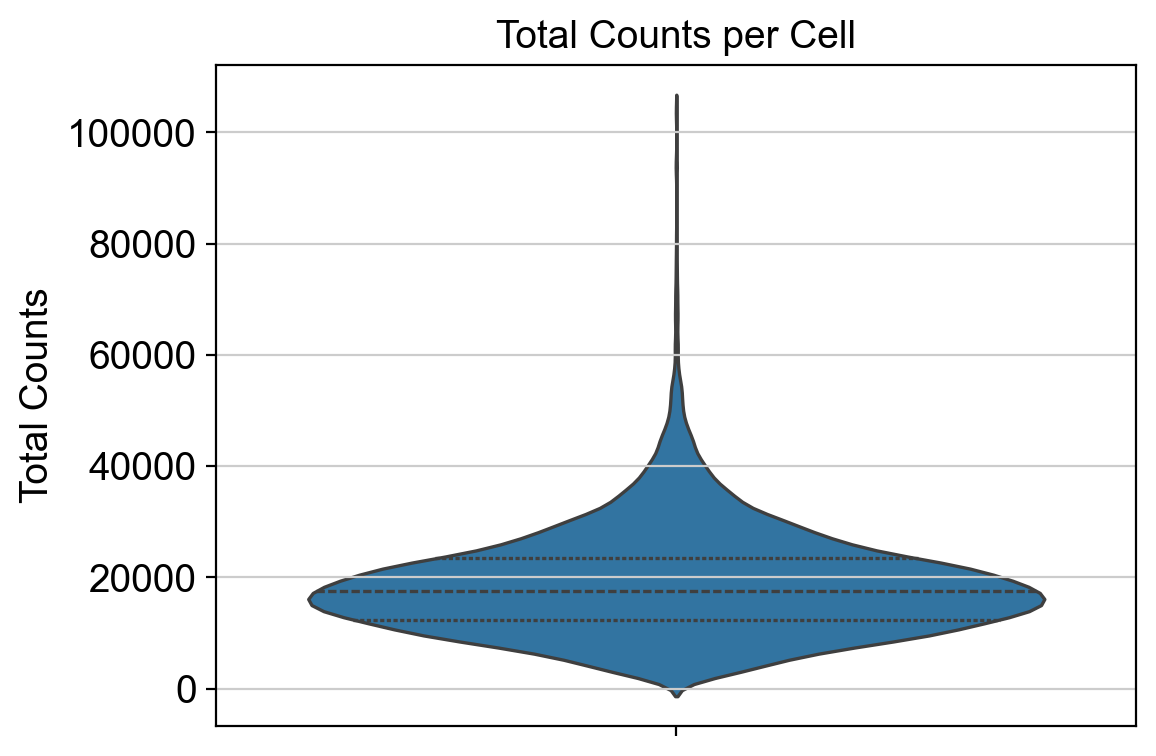

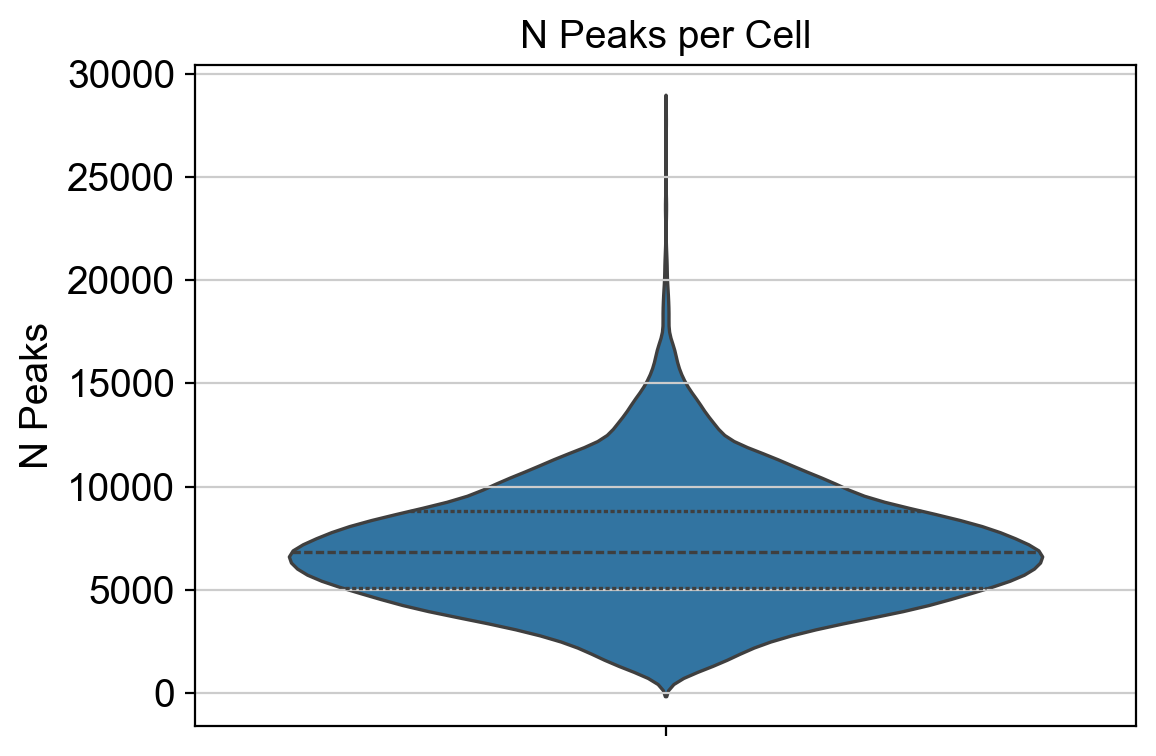

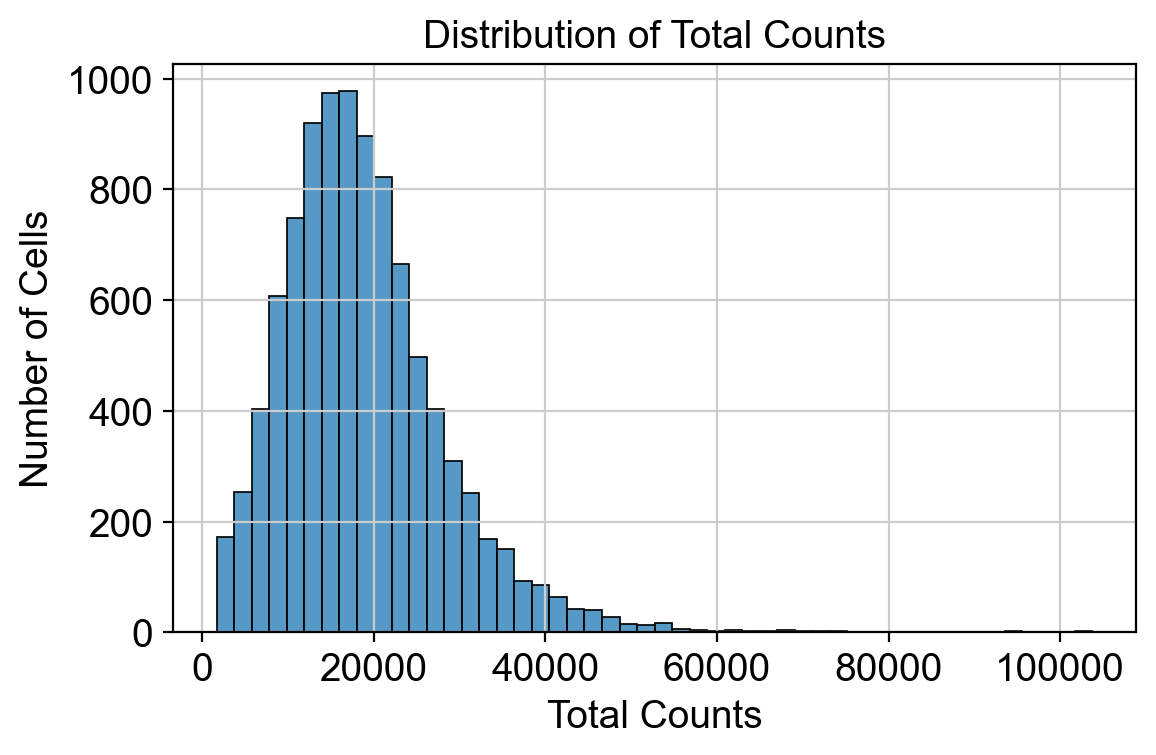

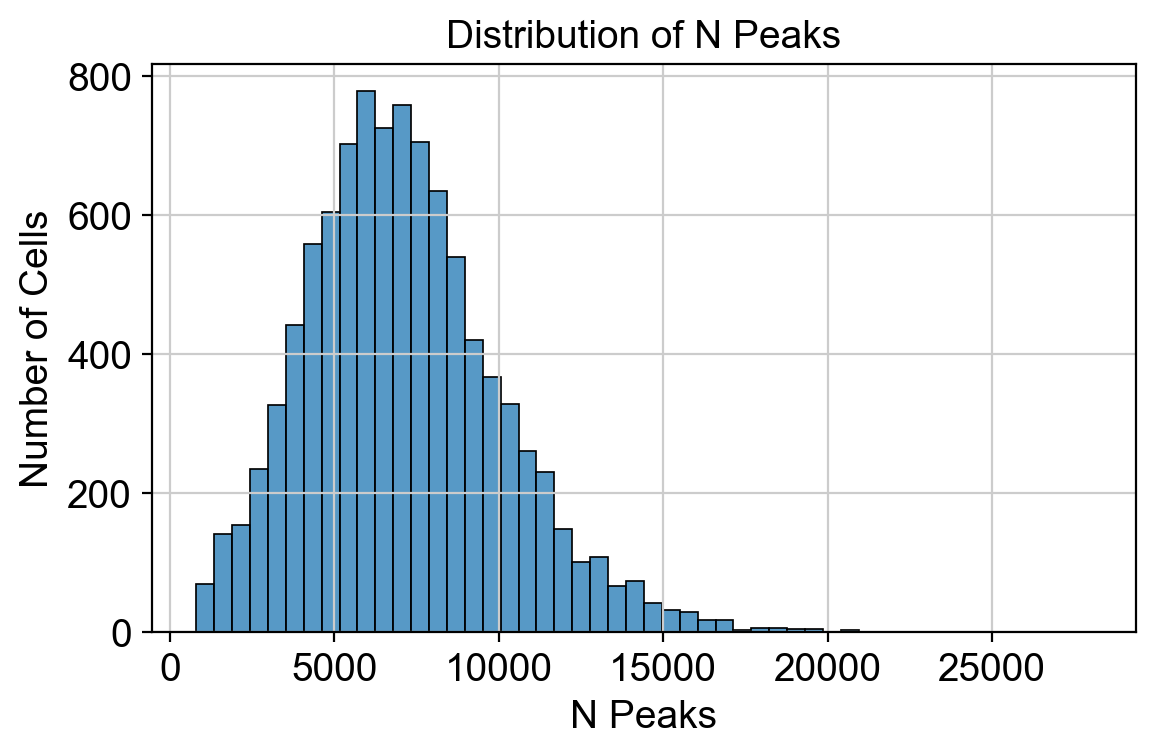

In [7]:
# ----------------------------------------
# 📊 QC Metric Visualization for scATAC-seq
# ----------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
os.makedirs("figures", exist_ok=True)

# Define QC metrics to visualize
qc_metrics = ['total_counts', 'n_peaks']

# 1. Violin plots
for metric in qc_metrics:
    plt.figure(figsize=(6, 4))
    sns.violinplot(y=adata.obs[metric], inner='quartile', linewidth=1.2)
    plt.title(f"{metric.replace('_', ' ').title()} per Cell")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.tight_layout()
    output_path = f"figures/violin_{metric}.png"
    plt.savefig(output_path)
    plt.show()  # ✅ display in notebook

# 2. Histograms
for metric in qc_metrics:
    plt.figure(figsize=(6, 4))
    sns.histplot(adata.obs[metric], bins=50, kde=False)
    plt.title(f"Distribution of {metric.replace('_', ' ').title()}")
    plt.xlabel(metric.replace('_', ' ').title())
    plt.ylabel("Number of Cells")
    plt.tight_layout()
    output_path = f"figures/hist_{metric}.png"
    plt.savefig(output_path)
    plt.show()  # ✅ display in notebook


In [ ]:

#The quality control summary, supported by histograms and violin plots, revealed a broad but reasonable distribution of total fragments (total_counts) and accessible regions (n_peaks) per cell.
#These plots clearly illustrate that most cells fall within expected healthy ranges—typically 5,000–50,000 fragments and 3,000–15,000 peaks. 
#Cells below these thresholds may represent low-complexity or damaged captures, while those with extremely high counts could be potential doublets. 
#In our dataset, the absence of outliers in these visualizations and the fact that all 9,668 cells passed the QC thresholds support the conclusion that the dataset is of high quality and ready for downstream analyses.


In [12]:
# ---------------------------------------------------------
# Step 3: Preprocessing and Dimensionality Reduction for scATAC-seq
# ---------------------------------------------------------

# In this step, we normalized the sparse peak-by-cell count matrix to account for differences in sequencing depth across cells (library size). 
# We then applied a log transformation to stabilize variance and highlight biologically meaningful differences in chromatin accessibility.
# Dimensionality reduction was performed using Singular Value Decomposition (SVD) on the top variable peaks (akin to PCA for scRNA-seq), 
# producing Latent Semantic Indexing (LSI) components that capture the major patterns of chromatin accessibility.
# Finally, we used UMAP to project the cells into a low-dimensional space, enabling visualization of potential cell populations and structure.


import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

# -------------------------------------------
# 1. TF-IDF Normalization (common in scATAC)
# -------------------------------------------

# Term Frequency (TF)
tf = adata.X.copy()
tf.data = tf.data / np.repeat(tf.sum(axis=1).A, np.diff(tf.indptr))

# Inverse Document Frequency (IDF)
idf = np.log(1 + adata.n_obs / (1 + (adata.X > 0).sum(axis=0).A1))
tfidf = tf.multiply(idf)

print("✅ TF-IDF normalization complete")

# ------------------------------------------------
# 2. Latent Semantic Analysis (LSA) via SVD
# ------------------------------------------------

n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=0)
X_svd = svd.fit_transform(tfidf)

# Save SVD result to AnnData object
adata.obsm['X_lsa'] = X_svd
print(f"✅ SVD complete. Shape of LSA result: {X_svd.shape}")

# --------------------------------------------
# 3. Neighborhood graph and UMAP projection
# --------------------------------------------

# Compute neighborhood graph using LSA embedding
sc.pp.neighbors(adata, use_rep='X_lsa', n_neighbors=15)

# Compute UMAP
sc.tl.umap(adata)
print("✅ UMAP projection complete")

# --------------------------------------------
# 4. Clustering using Leiden algorithm
# --------------------------------------------

sc.tl.leiden(adata, resolution=0.5)
print("✅ Leiden clustering complete")

# --------------------------------------------


✅ TF-IDF normalization complete
✅ SVD complete. Shape of LSA result: (9668, 50)
computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:09)
✅ UMAP projection complete
running Leiden clustering
    finished (0:00:02)
✅ Leiden clustering complete


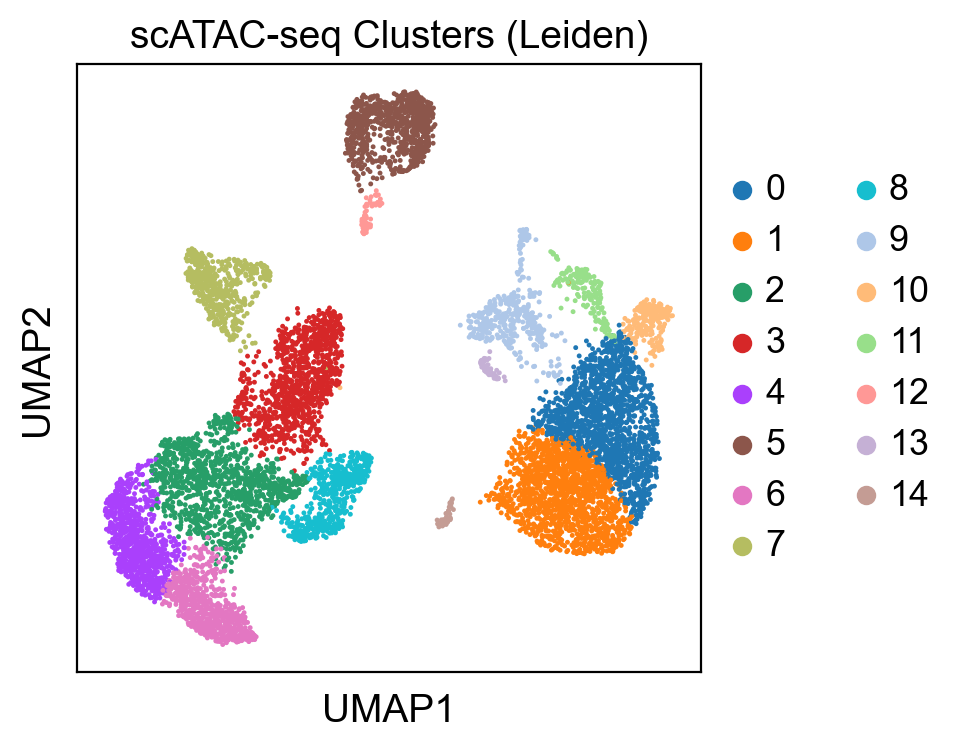

In [16]:
# --------------------------------------------
# 5. Plotting results
# --------------------------------------------

# UMAP colored by clusters
sc.pl.umap(adata, color='leiden', title="scATAC-seq Clusters (Leiden)")


In [ ]:

# UMAP colored by clusters (Leiden):
# This UMAP projection shows distinct groupings of cells identified using the Leiden clustering algorithm.
# Each color represents a separate cluster, corresponding to a subpopulation of cells with similar chromatin accessibility profiles.
# The clear separation between clusters suggests the presence of biologically meaningful subtypes or states.
# This clustering structure provides a foundation for downstream analyses such as marker peak identification and motif enrichment.


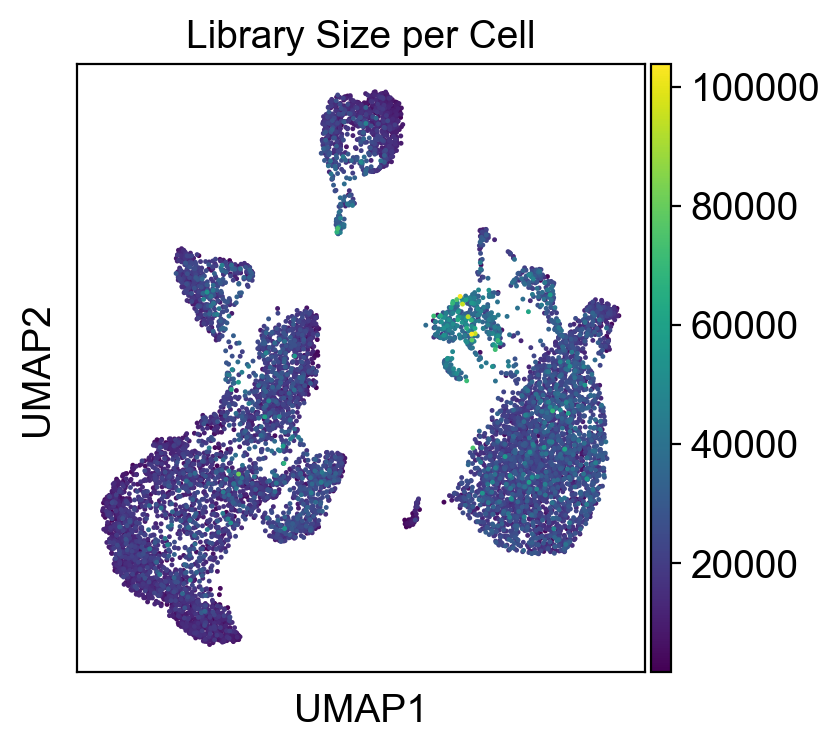

In [17]:

# UMAP colored by total fragments (library size)
sc.pl.umap(adata, color='total_counts', title="Library Size per Cell")


In [ ]:

# UMAP colored by total fragments (library size):
# This UMAP plot displays the total number of fragments (library size) per cell across the 2D projection.
# A smooth distribution of colors across clusters suggests that sequencing depth is relatively uniform.
# This is a good indication that technical variability from library size is not influencing the clustering structure.
# Cells with exceptionally high counts would appear as hotspots and may represent potential doublets, 
# but no such anomalies are evident in this dataset.


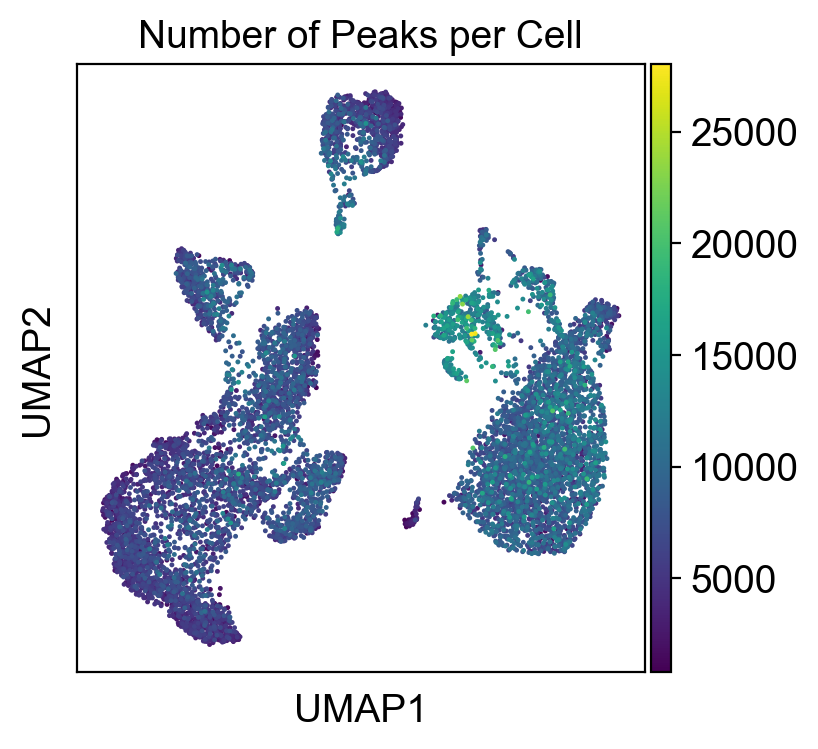

In [18]:

# UMAP colored by number of peaks detected
sc.pl.umap(adata, color='n_peaks', title="Number of Peaks per Cell")


In [ ]:
# UMAP colored by number of accessible peaks:
# Here, the number of accessible chromatin regions detected per cell (n_peaks) is visualized in UMAP space.
# Similar to the library size, an even distribution indicates that data complexity is consistent across clusters.
# This supports the conclusion that the identified clusters likely represent true biological differences.
